In [8]:
import math

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx
import pandas as pd
import pyproj
import seaborn as sns
import shapely
from geopy import distance

In [9]:
DaytonDf = pd.read_csv("13/Dayton.csv")
roadNetwork = osmnx.io.load_graphml("data/road.graphml")
study_area = osmnx.geocode_to_gdf("Dayton")

In [10]:
DaytonDf.columns

Index(['Unnamed: 0', 'ID', 'Source', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Street', 'City', 'County', 'State', 'Zipcode',
       'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [61]:
nodes, edges = osmnx.graph_to_gdfs(roadNetwork)

In [12]:
# discardind datapoints that are too far from Dayton
buffer = 1
minX = min(nodes["x"]) - buffer
maxX = max(nodes["x"]) + buffer
minY = min(nodes["y"]) - buffer
maxY = max(nodes["y"]) + buffer
DaytonDf = DaytonDf[
    (DaytonDf["Start_Lng"] > minX)
    & (DaytonDf["Start_Lng"] < maxX)
    & (DaytonDf["Start_Lat"] > minY)
    & (DaytonDf["Start_Lat"] < maxY)
]

In [13]:
print(minX, maxX, minY, maxY)

-85.276064 -83.0961276 38.705933 40.8105344


In [14]:
DaytonDf.shape[0]

23414

In [15]:
# Make coodrinate as a tuple
DaytonDf["start_coordinate"] = DaytonDf.apply(
    lambda x: shapely.Point(x["Start_Lng"], x["Start_Lat"]), axis=1
)

In [96]:
# Buffering geometry to make a map where accidents took place
edges["buffered_geometry"] = edges.copy()["geometry"].apply(
    lambda geom: geom.buffer(0.01)
)

In [118]:
# Caluclate edges accident counts
edges["accident_count"] = edges.apply(
    lambda x: len(
        DaytonDf[x["buffered_geometry"].intersects(DaytonDf["start_coordinate"])]
    ),
    axis=1,
)

In [18]:
# I query alcholos shops, to see if there is a correlation
place_name = "Dayton, Ohio, USA"

tags = {"shop": "alcohol"}

alcohol_shops = osmnx.features_from_place(place_name, tags)

/tmp/ipykernel_40660/4020929701.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ].centroid


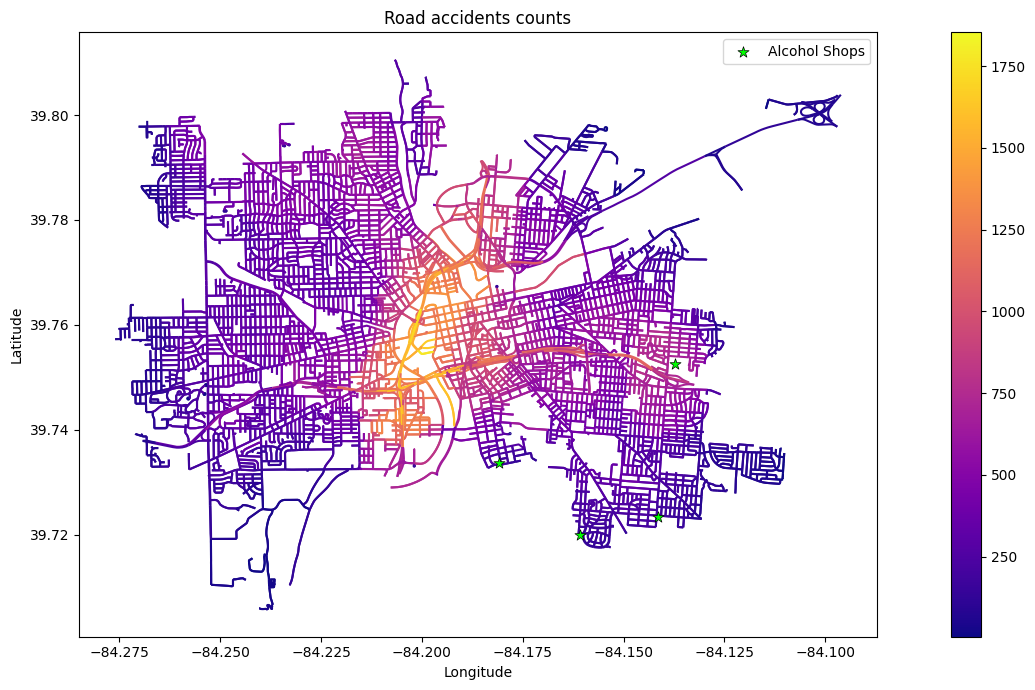

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# Plot accident counts
edges.plot(column="accident_count", cmap="plasma", legend=True, ax=ax, zorder=1)
ax.set_title("Road accidents counts")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Separate alcohol shops
alcohol_shops_points = alcohol_shops[alcohol_shops.geometry.type == "Point"]
alcohol_shops_polygons = alcohol_shops[
    alcohol_shops.geometry.type.isin(["Polygon", "MultiPolygon"])
]

# Convert polygons to centroids
alcohol_shops_polygons_centroids = alcohol_shops_polygons.copy()
alcohol_shops_polygons_centroids["geometry"] = alcohol_shops_polygons_centroids[
    "geometry"
].centroid

# Combine all Points (original + centroids)
all_alcohol_shops = gpd.GeoDataFrame(
    pd.concat(
        [alcohol_shops_points, alcohol_shops_polygons_centroids], ignore_index=True
    )
)

# IMPORTANT: assign CRS
all_alcohol_shops = all_alcohol_shops.to_crs(alcohol_shops.crs)
# Plot all alcohol shops as stars
all_alcohol_shops.plot(
    ax=ax,
    color="lime",
    markersize=70,
    marker="*",
    edgecolor="black",
    linewidth=0.5,
    label="Alcohol Shops",
    zorder=5,
)

ax.legend()

plt.tight_layout()
plt.show()

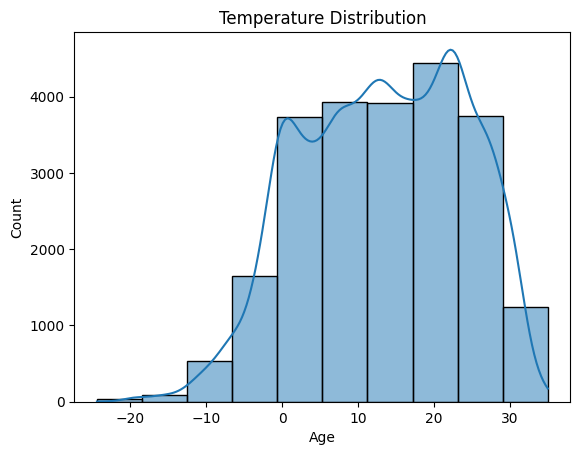

In [20]:
DaytonDf["Temperature(C)"] = DaytonDf["Temperature(F)"].apply(
    lambda x: (x - 32) * (5 / 9)
)
sns.histplot(DaytonDf["Temperature(C)"], bins=10, kde=True)
plt.title("Temperature Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

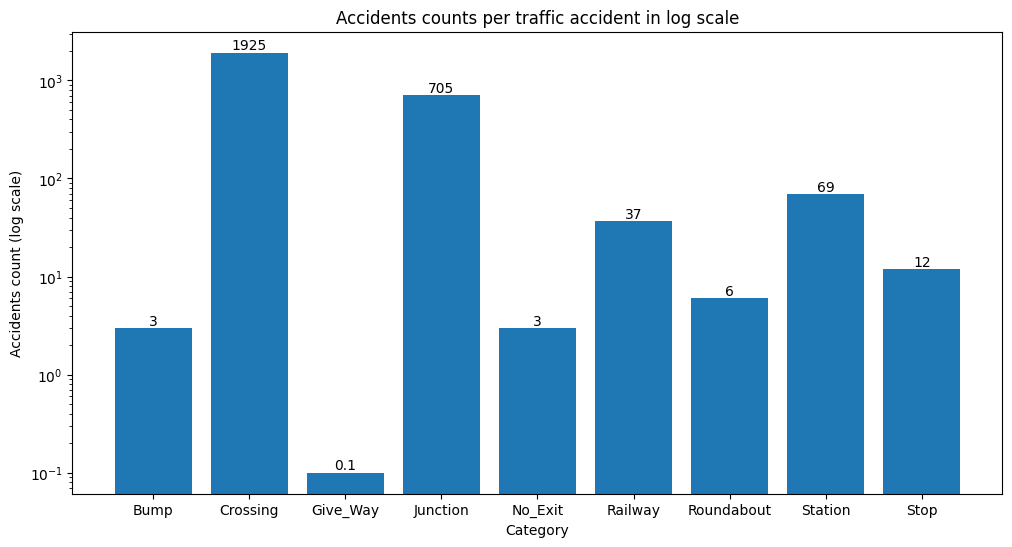

In [21]:
traffic_object = [
    "Bump",
    "Crossing",
    "Give_Way",
    "Junction",
    "No_Exit",
    "Railway",
    "Roundabout",
    "Station",
    "Stop",
]
object_accidents = {}
for el in traffic_object:
    object_accidents[el] = len(DaytonDf[DaytonDf[el] == True][el])
cleaned = {k: (v if v > 0 else 0.1) for k, v in object_accidents.items()}
labels = list(cleaned.keys())
values = list(cleaned.values())

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(labels, values, log=True)
for i in range(len(bars)):
    bar = bars[i]
    yval = values[i]
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha="center", va="bottom")

ax.set_ylabel("Accidents count (log scale)")
ax.set_xlabel("Category")
ax.set_title("Accidents counts per traffic accident in log scale")
plt.show()

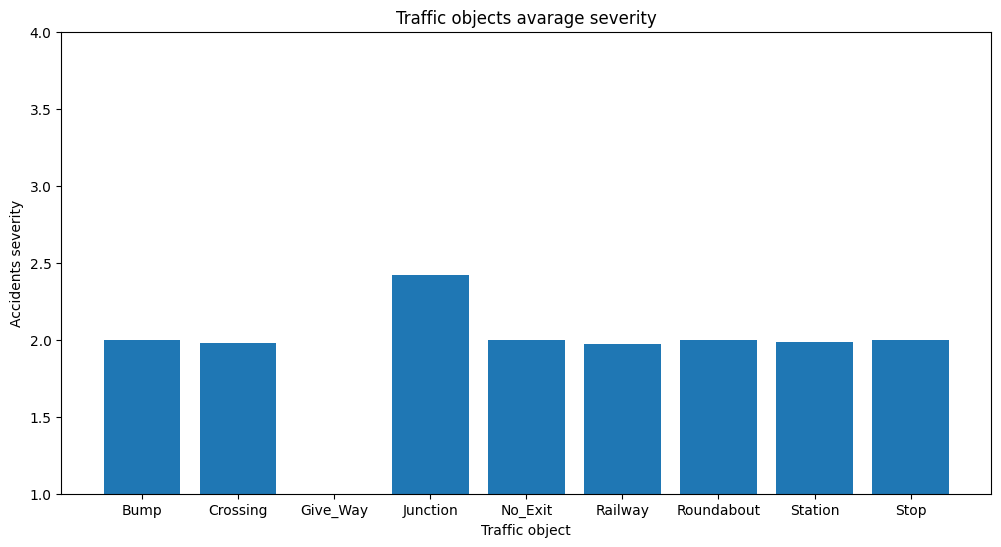

In [127]:
object_mean_severity = list(
    map(lambda x: DaytonDf[DaytonDf[x] == True]["Severity"].mean(), traffic_object)
)
object_mean_severity = list(
    map(lambda x: x if not math.isnan(x) else 0, object_mean_severity)
)
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(traffic_object, object_mean_severity)

ax.set_ylabel("Accidents severity")
ax.set_xlabel("Traffic object")
ax.set_title("Traffic objects avarage severity")
ax.set_ylim(1, 4)
plt.show()

/tmp/ipykernel_40660/1108926213.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_severity = DaytonDf.groupby("Temp_Bin")["Severity"].mean().reset_index()
/tmp/ipykernel_40660/1108926213.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_severity, x="Temp_Bin", y="Severity", palette="viridis")


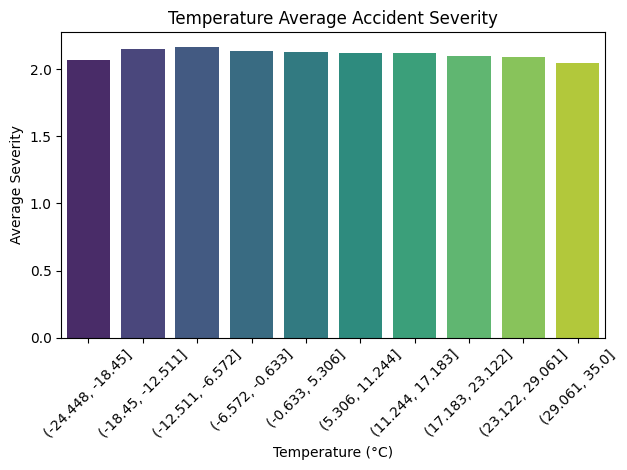

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Convert temperature from Fahrenheit to Celsius
DaytonDf["Temperature(C)"] = DaytonDf["Temperature(F)"].apply(
    lambda x: (x - 32) * (5 / 9)
)

# Calculate average severity for temperature bins
DaytonDf["Temp_Bin"] = pd.cut(DaytonDf["Temperature(C)"], bins=10)
avg_severity = DaytonDf.groupby("Temp_Bin")["Severity"].mean().reset_index()

# Plotting
sns.barplot(data=avg_severity, x="Temp_Bin", y="Severity", palette="viridis")
plt.xticks(rotation=45)
plt.title("Temperature Average Accident Severity")
plt.xlabel("Temperature (°C)")
plt.ylabel("Average Severity")
plt.tight_layout()
plt.show()

In [24]:
DaytonDf["Source"].value_counts()

Source
Source2    15987
Source1     7205
Source3      222
Name: count, dtype: int64

In [25]:
edges["avg_severity"] = edges.apply(
    lambda x: DaytonDf[x["buffered_geometry"].intersects(DaytonDf["start_coordinate"])]["Severity"].mean(),
    axis=1,
)

/tmp/ipykernel_40660/1899322800.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


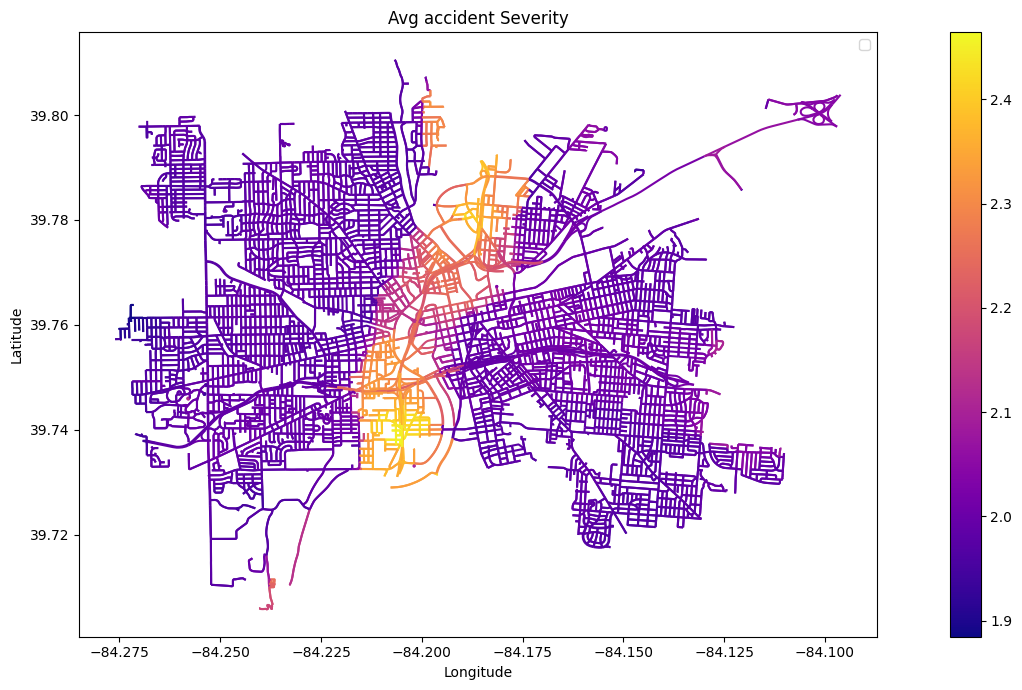

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# Plot edges mean severity
edges.plot(column="avg_severity", cmap="plasma", legend=True, ax=ax, zorder=1)
ax.set_title("Avg accident Severity")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


ax.legend()

plt.tight_layout()
plt.show()

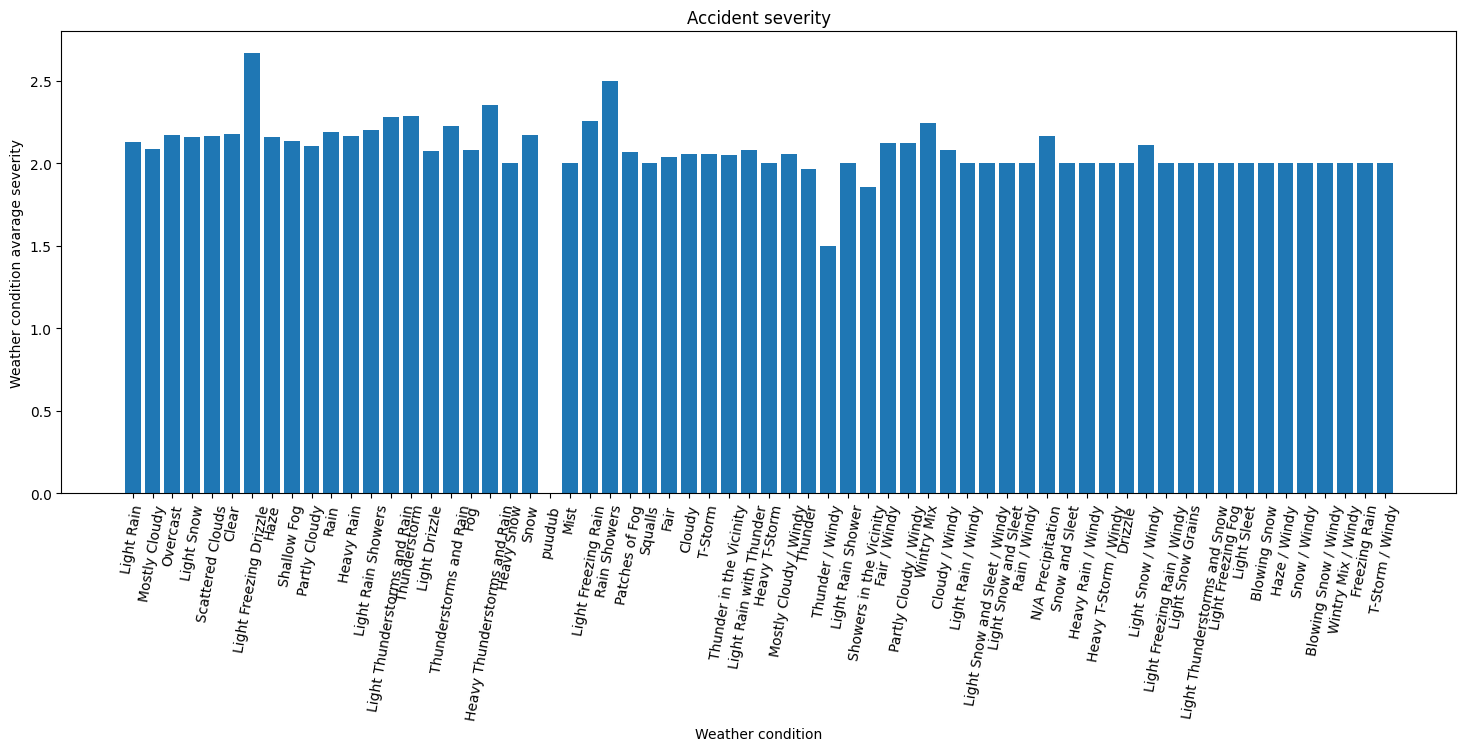

In [27]:
weather_conditions = list(DaytonDf["Weather_Condition"].unique())
weather_conditions = list(
    map(lambda x: x if isinstance(x, str) else "puudub", weather_conditions)
)
avg_severity = list(
    map(
        lambda x: DaytonDf[DaytonDf["Weather_Condition"] == x]["Severity"].mean(),
        weather_conditions,
    )
)
avg_severity = list(map(lambda x: x if not math.isnan(x) else 0, avg_severity))
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(weather_conditions, avg_severity)

ax.set_ylabel("Weather condition avarage severity")
ax.set_xlabel("Weather condition")
ax.set_title("Accident severity")
plt.xticks(rotation=80)
plt.show()

In [41]:
def saveEdges(edges):
    edges.to_csv("data/dayton_edges.csv")
    edges.to_file("data/dayton_edges.geojson", driver="GeoJSON")
saveEdges(edges)

In [87]:

#edges[["avg_severity", "accident_count"]]=gpd.read_file("data/dayton_edges.csv")[["avg_severity", "accident_count"]]
congestionData=pd.read_csv("data/DaytonCongestionsDf.csv")
congestionData["geometry"] = congestionData.apply(
    lambda row: shapely.Point(row["Start_Lng"], row["Start_Lat"]), axis=1
)

In [102]:
edges["avg_congestion_severity"] = edges.apply(
    lambda x: congestionData[x["buffered_geometry"].intersects(congestionData["geometry"])]["Severity"].mean(),
    axis=1,
)

In [107]:
edges["avg_congestion_count"] = edges.apply(
    lambda x: congestionData[x["buffered_geometry"].intersects(congestionData["geometry"])].shape[0],
    axis=1,
)

/tmp/ipykernel_40660/3718553947.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


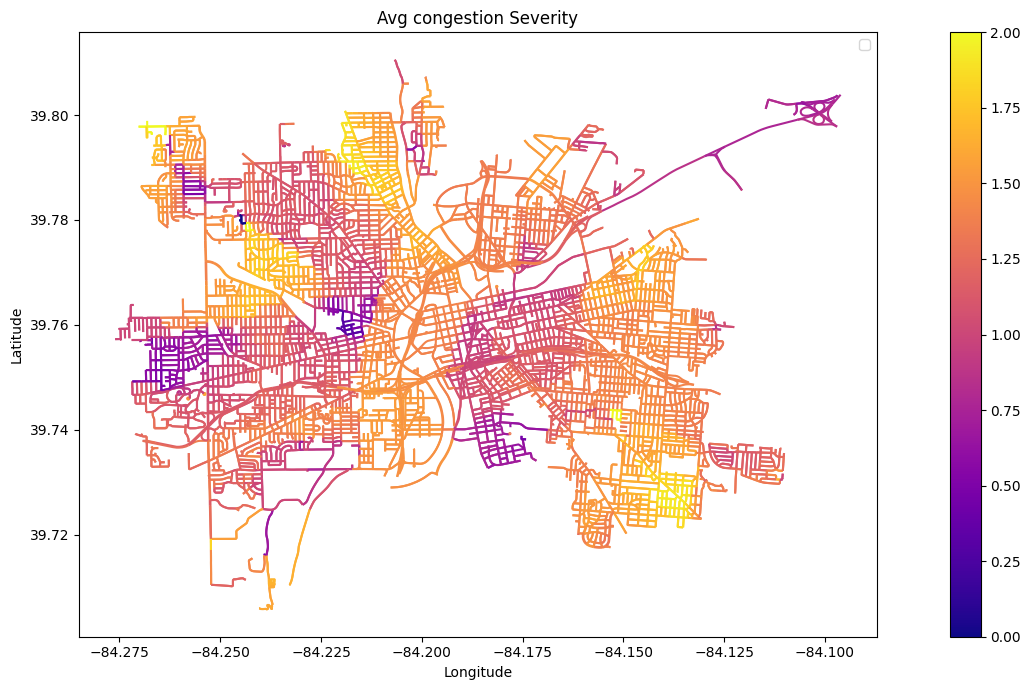

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# Plot edges mean severity
edges.plot(column="avg_congestion_severity", cmap="plasma", legend=True, ax=ax, zorder=1)
ax.set_title("Avg congestion Severity")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_40660/256532888.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


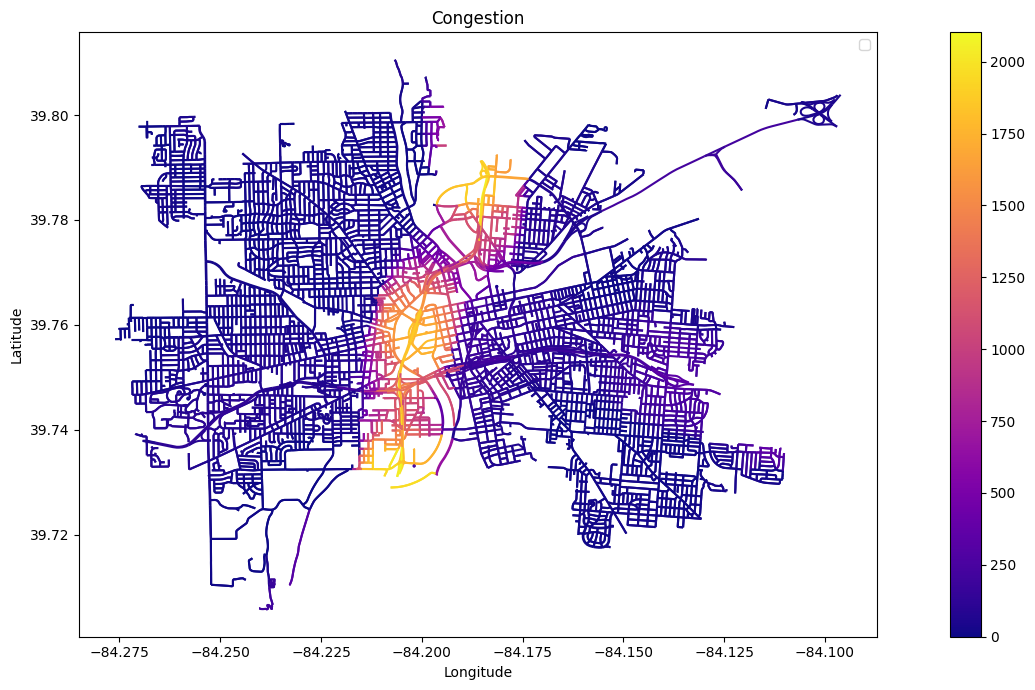

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# Plot edges mean severity
edges.plot(column="avg_congestion_count", cmap="plasma", legend=True, ax=ax, zorder=1)
ax.set_title("Congestion")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


ax.legend()

plt.tight_layout()
plt.show()

In [123]:
edges["accident_rate"]=(edges["accident_count"]/edges["avg_congestion_count"]).apply(lambda x: x if x <200 else 1)

/tmp/ipykernel_40660/2457654354.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


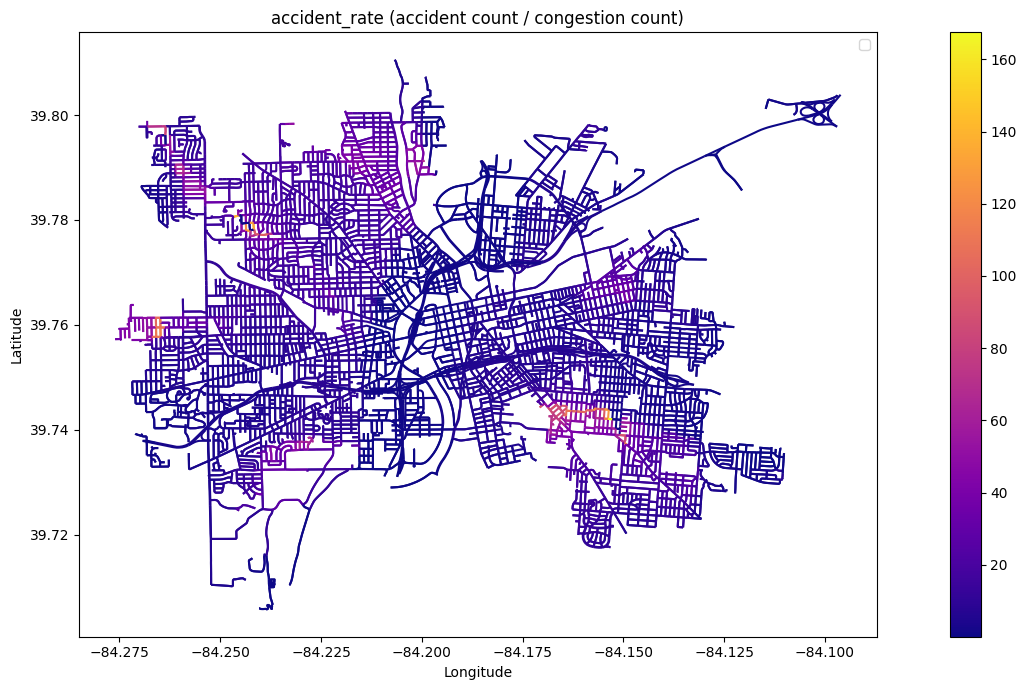

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# Plot edges mean severity
edges.plot(column="accident_rate", cmap="plasma", legend=True, ax=ax, zorder=1)
ax.set_title("accident_rate (accident count / congestion count)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


ax.legend()

plt.tight_layout()
plt.show()